In [2]:
import warnings
warnings.filterwarnings('ignore')
import skmob
import geopandas as gpd
from skmob.utils import plot
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import paramiko

hostname = "xxxx"
username = "avitali"
remote_directory = "xxxx"

try:
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)


    sftp = ssh.open_sftp()

    files = sftp.listdir(remote_directory)
    count=0
    for file in files:
        count+=1
        print(file)
    print (count)

    sftp.close()
    ssh.close()

except Exception as e:
    print(f"An error occurred: {e}")


## Leggiamo e Puliamo i file


In [ ]:
import paramiko
import gzip
import io
import traceback

dates = ['20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217']
hostname = "xxxx"
username = "avitali"

dataframes = {}

try:
    # Apriamo le connessioni SSH & SFTP 
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)
    
    sftp = ssh.open_sftp()

    for date in dates:
        remote_file_path = f"xxxx{date}_0.csv.gz"
        
        try:
            with sftp.open(remote_file_path, "rb") as remote_file:
                with gzip.GzipFile(fileobj=remote_file) as decompressed_file:
                    
                    chunks = []
                    all_dataframes = []  # Processiamo per chunks e li salviamo qua
                    print(f"Reading lines from the file for {date}...")
                    
                    for i, line in enumerate(decompressed_file):
                        chunks.append(line.decode("utf-8").strip())
                        
                        # Processiamo in chunks di 100000
                        if len(chunks) >= 100000:
                            print(f"Processing chunk at line {i + 1} for {date}...")
                            dataframe_chunk = pd.read_csv(io.StringIO("\n".join(chunks)), header=None)
                            all_dataframes.append(dataframe_chunk)  # Salvo il chunk
                            chunks = []  # Pulisce buffer
                    
                    # Processa le linee rimanenti se le linee non sono divisibili per 100000
                    if chunks:
                        print(f"Processing the final chunk for {date}...")
                        dataframe_chunk = pd.read_csv(io.StringIO("\n".join(chunks)), header=None)
                        all_dataframes.append(dataframe_chunk)  # Salva il chunk finale
                    
                    # Combina tutti i chunk in in un df
                    print(f"Combining all chunks into a final DataFrame for {date}...")
                    final_dataframe = pd.concat(all_dataframes, ignore_index=True)
                    
                    print(f"Final DataFrame for {date} (showing first 3 rows):")
                    print(final_dataframe.head(3))
                    dataframes[date] = final_dataframe  # Mette il df in un dizionario

        except Exception as file_error:
            print(f"Error occurred while processing the file for {date}: {file_error}")
            traceback.print_exc()

    # Chiude le connessioni SFTP and SSH
    sftp.close()
    ssh.close()

except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc() #mi dice dove è venuto l'errore


In [6]:
for date, df in dataframes.items():
    print(date, len(df))

20190211 1025094
20190212 1039055
20190213 1065370
20190214 1107852
20190215 1121731
20190216 1034149
20190217 859602


In [ ]:
dataframes.to

In [ ]:
# Dividiamo le coordinate per 1 milione per tutto il dizionario
for date, df in dataframes.items():
    df[3] = df[3] / 1_000_000
    df[4] = df[4] / 1_000_000
    print(f"df for {date}:{df.head(2)}")

In [ ]:
## Creiamo il gdf

from shapely.geometry import Point
gdfs={}
for date, df in dataframes.items():
    geometry = gpd.points_from_xy(df[4], df[3]) 
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.set_crs(epsg=4326, inplace=True)
    gdfs[date]=gdf
    print(gdfs[date].head(2))
    print(f"{date,df} converted")

In [ ]:
for date, gdf in gdfs.items():
    print(date, gdf.dtypes)

In [10]:
for date, gdf in gdfs.items():
    gdfs[date] = gdf.reset_index(drop=True)


<Figure size 1500x1500 with 0 Axes>

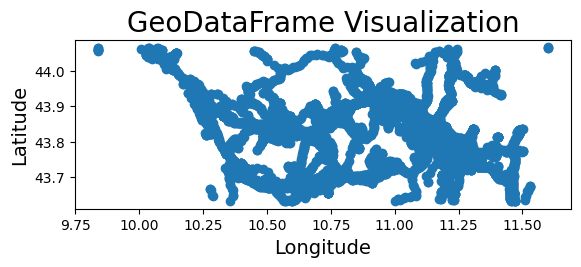

In [223]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))  
gdf.head(10000).plot()

plt.title("GeoDataFrame Visualization", fontsize=20)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.show()

In [ ]:
for date, gdf in gdfs.items():
    print(f"GeoDataFrame for date: {date}")
    print("First row of the GeoDataFrame:")
    print(gdf.head(1))
    print("\nGeoDataFrame Info:")
    gdf.info()  # info fa già il print
    print("\nCoordinate Reference System (CRS):")
    print(gdf.crs)
    print("\nFirst geometry object:")
    print(gdf.geometry.head(1))
    print("-" * 50)  

In [11]:
#N.B. Non salva con colonne numeriche!

for date, gdf in gdfs.items():
    gdf.columns = ['ID', 'Date', 'Time', 'Latitude', 'Longitude', 'Speed', 'Heading', 'Quality', 'PanelSession', 'DeltaPos', 'geometry']
    gdfs[date]= gdf


#ID_ANONYMOUS,DAY,HH24,LATITUDE,LONGITUDE,SPEED,HEADING,QUALITY,ID_PANELSESSION,DELTAPOS
#Ovvero le ultime colonne sono la velocità (km/h, credo) , direzione (gradi, 0 = nord, non mi ricordo se in senso orario), 
#qualità del segnale (è consigliato buttare via quelli < 3), stato del veicolo (0=accensione, 1=in moto, 2=spegnimento), 
#distanza in metri dal punto precedente.

#try:
    #gdf.to_file("PrimoGennaioGPS.geojson", driver="GeoJSON")
    #print("GeoDataFrame saved successfully.")
#except Exception as e:
    #print(f"Error saving GeoDataFrame: {e}")

In [17]:
gdfs['20190211'].head(2)

,ID,Date,Time,Latitude,Longitude,Speed,Heading,Quality,PanelSession,DeltaPos,geometry
0,55,2019-02-09,07:59:17,43.875767,10.800906,0,0,3,2,1038,POINT (10.80091 43.87577)
1,55,2019-02-09,10:51:53,43.874915,10.801647,2,152,3,0,0,POINT (10.80165 43.87492)


### Filtriamo i valori con qualità segnale <3

In [12]:
for date, gdf in gdfs.items():
    print(date, gdf['Quality'].unique())

20190211 [3 1 2]
20190212 [3 1 2]
20190213 [1 3 2]
20190214 [3 1 2]
20190215 [3 1 2]
20190216 [3 1 2]
20190217 [3 1 2]


In [13]:
for date, gdf in gdfs.items():
    gdf2=gdf[gdf['Quality']==3]
    gdf2=gdf2.drop(columns=['Quality'])
    gdfs[date]=gdf2

In [14]:
for date, gdf in gdfs.items():
    print(len(gdf))

890180
901239
925858
963612
977355
904101
764563


### Filtriamo le date

In [15]:
for date, gdf in gdfs.items():
    unique_dates = gdf['Date'].unique()
    print(f"Unique Dates: in {date}: {unique_dates}")
    data=f"{date[0:4]}-{date[4:6]}-{date[6:8]}"
    gdf1=gdf[gdf['Date']==data]
    gdfs[date]=gdf1

Unique Dates: in 20190211: ['2019-02-09' '2019-02-11' '2019-02-10' '2019-02-06' '2019-02-08'
 '2019-02-04' '2019-02-07' '2019-01-15' '2019-02-05' '2019-01-31'
 '2019-02-03' '2019-02-02' '2019-01-29' '2019-01-30' '2019-02-01'
 '2019-01-24' '2019-01-25' '2019-01-28' '2019-01-04' '2019-01-02']
Unique Dates: in 20190212: ['2019-02-11' '2019-02-12' '2019-02-10' '2019-02-07' '2019-02-09'
 '2019-02-08' '2019-02-06' '2019-02-05' '2019-01-28' '2019-01-30'
 '2019-02-01' '2019-01-31' '2019-01-26' '2019-02-04' '2019-02-02'
 '2019-02-03' '2019-01-21' '2019-01-11' '2019-01-12' '2019-01-14'
 '2019-01-15' '2019-01-17' '2019-01-18' '2019-01-07' '2019-01-29']
Unique Dates: in 20190213: ['2019-02-13' '2019-02-12' '2019-02-11' '2019-02-09' '2019-02-10'
 '2019-02-06' '2019-02-08' '2019-01-06' '2019-02-07' '2019-01-26'
 '2019-02-03' '2019-02-05' '2019-01-31' '2019-01-10' '2019-01-21'
 '2019-01-22' '2019-01-24' '2019-01-25' '2019-02-04' '2019-02-02'
 '2019-01-04' '2019-02-01' '2019-01-30']
Unique Dates: in 2

In [16]:
for date, gdf in gdfs.items():
    unique_dates = gdf['Date'].unique()
    print(f"Unique Dates: in {date}: {unique_dates}")

Unique Dates: in 20190211: ['2019-02-11']
Unique Dates: in 20190212: ['2019-02-12']
Unique Dates: in 20190213: ['2019-02-13']
Unique Dates: in 20190214: ['2019-02-14']
Unique Dates: in 20190215: ['2019-02-15']
Unique Dates: in 20190216: ['2019-02-16']
Unique Dates: in 20190217: ['2019-02-17']


In [23]:
for date, gdf in gdfs.items():
    print(len(gdf))

817467
826184
849465
884131
890294
819406
679852


In [233]:
#Percentuale dati effettivamente giusti
len(gdf3)/len(gdf2)*100

88.4959485248123

## Filtriamo i punti dentro l'area della FIPILI FIRENZE-LASTRA

In [3]:
fipili_area_FI_Lastra = gpd.read_file("internship/ArealeRistretto_FIPILI/Buffer10m/FIRENZE_LASTRA.shp")

In [4]:
fipili_area_FI_Lastra.head(1)

,pk_uid,cod_ele,tip_ele,tipo_ele,cls_tcn,clstecfun,tip_gst,tip_gest,cod_gst,sot_pas,...,l_struct,lstruttura,r_struct,rstruttura,primaria,data_agg,data_elab,tipostrada,cent,geometry
0,223583,RT04802418288ES,0100,di tronco carreggiata,0100,autostrada,0300,Provincia,048,0500,...,-1,-,-1,-,1,20190904,20191024,SR,None,"POLYGON ((1671205.987 4848520.012, 1671193.707..."


In [6]:
import folium

latitude = 43.7696
longitude = 11.2558
map_f = folium.Map(location=[latitude, longitude], zoom_start=8, tiles='CartoDB positron')


folium.GeoJson(
    fipili_area_FI_Lastra,
    tooltip=folium.GeoJsonTooltip(
        fields=['pk_uid', 'tipo_ele'],
        aliases=['ID:', 'Type:']
    )
).add_to(map_f)

map_f.save('Firenze_Lastra.html')
map_f


In [19]:
for date, gdf in gdfs.items():
    print(date, gdf['ID'].nunique())

20190211 23693
20190212 23704
20190213 23812
20190214 24224
20190215 24416
20190216 22726
20190217 19963


In [ ]:
fipili_area_FI_Lastra = gpd.read_file("internship/ArealeRistretto_FIPILI/Buffer10m/FIRENZE_LASTRA.shp")

In [77]:
gdfs_FI_LASTRA={}
for date, gdf in gdfs.items():
    gdf = gdf.to_crs(fipili_area_FI_Lastra.crs)
    points_in_area = gpd.sjoin(gdf, fipili_area_FI_Lastra, how="inner", predicate="within")
    uid_counts = points_in_area.groupby('ID').size()
    print(f"Number of points within FI-LASTRA on {date}: {len(points_in_area)}")
    print(f"Number of Unique IDs using FI-LASTRA on {date}:{points_in_area['ID'].nunique()}")
    valid_ID=uid_counts[uid_counts>=3].index
    gdf_FI_LASTRA = gdf[gdf['ID'].isin(valid_ID)]
    print(f"{date}: Filtered GeoDataFrame has {len(gdf_FI_LASTRA)} rows.")
    gdfs_FI_LASTRA[date]=gdf_FI_LASTRA

Number of points within FI-LASTRA on 20190211: 3065
Number of Unique IDs using FI-LASTRA on 20190211:818
20190211: Filtered GeoDataFrame has 41493 rows.
Number of points within FI-LASTRA on 20190212: 3253
Number of Unique IDs using FI-LASTRA on 20190212:830
20190212: Filtered GeoDataFrame has 43872 rows.
Number of points within FI-LASTRA on 20190213: 3216
Number of Unique IDs using FI-LASTRA on 20190213:836
20190213: Filtered GeoDataFrame has 44884 rows.
Number of points within FI-LASTRA on 20190214: 3342
Number of Unique IDs using FI-LASTRA on 20190214:866
20190214: Filtered GeoDataFrame has 47414 rows.
Number of points within FI-LASTRA on 20190215: 3609
Number of Unique IDs using FI-LASTRA on 20190215:970
20190215: Filtered GeoDataFrame has 53554 rows.
Number of points within FI-LASTRA on 20190216: 3336
Number of Unique IDs using FI-LASTRA on 20190216:928
20190216: Filtered GeoDataFrame has 46407 rows.
Number of points within FI-LASTRA on 20190217: 3064
Number of Unique IDs using FI-

In [72]:
gdfs_FI_LASTRA={}
for date, gdf in gdfs.items():
    gdf = gdf.to_crs(fipili_area_FI_Lastra.crs)
    points_in_area = gpd.sjoin(gdf, fipili_area_FI_Lastra, how="inner", predicate="within")
    uid_counts = points_in_area.groupby('ID').size()
    print(f"Number of points within FI-LASTRA on {date}: {len(points_in_area)}")
    print(f"Number of Unique IDs using FI-LASTRA on {date}:{points_in_area['ID'].nunique()}")
    valid_ID=uid_counts[uid_counts>=3].index
    gdf_FI_LASTRA = gdf[gdf['ID'].isin(valid_ID)]
    print(f"{date}: Filtered GeoDataFrame has {len(gdf_FI_LASTRA)} rows.")
    gdfs_FI_LASTRA[date]=gdf_FI_LASTRA

Number of points within FI-LASTRA on 20190211: 10295
Number of Unique IDs using FI-LASTRA on 20190211:984
20190211: Filtered GeoDataFrame has 63792 rows.
Number of points within FI-LASTRA on 20190212: 10764
Number of Unique IDs using FI-LASTRA on 20190212:991
20190212: Filtered GeoDataFrame has 66635 rows.
Number of points within FI-LASTRA on 20190213: 10569
Number of Unique IDs using FI-LASTRA on 20190213:999
20190213: Filtered GeoDataFrame has 68831 rows.
Number of points within FI-LASTRA on 20190214: 10990
Number of Unique IDs using FI-LASTRA on 20190214:1025
20190214: Filtered GeoDataFrame has 71263 rows.
Number of points within FI-LASTRA on 20190215: 11802
Number of Unique IDs using FI-LASTRA on 20190215:1114
20190215: Filtered GeoDataFrame has 82251 rows.
Number of points within FI-LASTRA on 20190216: 10538
Number of Unique IDs using FI-LASTRA on 20190216:1105
20190216: Filtered GeoDataFrame has 72772 rows.
Number of points within FI-LASTRA on 20190217: 9487
Number of Unique IDs 

In [55]:
for date, gdf in gdfs_FI_LASTRA.items():
  print(gdfs_FI_LASTRA[date].head(1))

        ID        Date      Time  Latitude  Longitude  Speed  Heading  \
1991  2564  2019-02-11  08:38:33  43.80533  11.115726     22      112   

      PanelSession  DeltaPos                   geometry  
1991             1      2021  POINT (11.11573 43.80533)  
      ID        Date      Time   Latitude  Longitude  Speed  Heading  \
618  996  2019-02-12  08:01:30  44.010111  11.238962     58      140   

     PanelSession  DeltaPos                   geometry  
618             1      2017  POINT (11.23896 44.01011)  
        ID        Date      Time   Latitude  Longitude  Speed  Heading  \
1575  2257  2019-02-13  05:10:23  43.635353  11.006142     74       24   

      PanelSession  DeltaPos                   geometry  
1575             1      2053  POINT (11.00614 43.63535)  
        ID        Date      Time   Latitude  Longitude  Speed  Heading  \
4400  5514  2019-02-14  06:40:08  43.768102  11.287653      0      334   

      PanelSession  DeltaPos                  geometry  
4400   

In [78]:
gdfs_FI_LASTRA_Timestamps = {}
for date, gdf in gdfs_FI_LASTRA.items():
    gdf['Timestamp'] = gdf['Date'] + ' ' + gdf['Time']
    print(f"{date} {gdf.head(1)}")
    gdfs_FI_LASTRA_Timestamps[date] = gdf

20190211         ID        Date      Time  Latitude  Longitude  Speed  Heading  \
1991  2564  2019-02-11  08:38:33  43.80533  11.115726     22      112   

      PanelSession  DeltaPos                   geometry            Timestamp  
1991             1      2021  POINT (11.11573 43.80533)  2019-02-11 08:38:33  
20190212       ID        Date      Time   Latitude  Longitude  Speed  Heading  \
618  996  2019-02-12  08:01:30  44.010111  11.238962     58      140   

     PanelSession  DeltaPos                   geometry            Timestamp  
618             1      2017  POINT (11.23896 44.01011)  2019-02-12 08:01:30  
20190213         ID        Date      Time  Latitude  Longitude  Speed  Heading  \
4007  5514  2019-02-13  06:48:53  43.76817  11.287719      0        0   

      PanelSession  DeltaPos                   geometry            Timestamp  
4007             1         0  POINT (11.28772 43.76817)  2019-02-13 06:48:53  
20190214         ID        Date      Time   Latitude  Longitud

<Figure size 1500x1500 with 0 Axes>

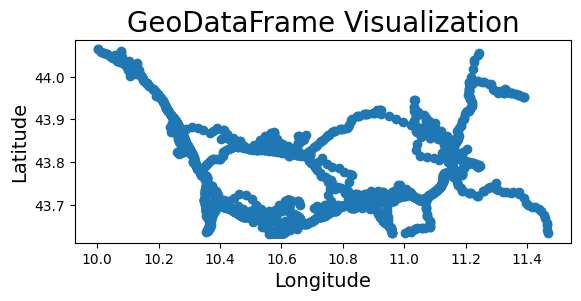

In [245]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))  # Set width and height in inches
gdf3_FIPILI.head(2000).plot()


plt.title("GeoDataFrame Visualization", fontsize=20)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)


plt.show()


In [79]:
# salviamo prima i gdfs singoli
import paramiko
import geopandas as gpd
import pandas as pd
import io
# Configurazione
hostname = "kddrtserver10.isti.cnr.it"
username = "avitali"

try:
    #apro connessione ssh
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)

    sftp = ssh.open_sftp()

    
    for date, gdf in gdfs_FI_LASTRA_Timestamps.items():
        print(f"Saving gdf {date} with head: {gdf.head(1)}")
        with sftp.open(f"/home/avitali/Filtered_FI_LASTRA_{date}.geojson", "w") as file:
            file.write(gdf.to_json())

        print(f"GeoJSON file {date} saved successfully at /home/avitali/Filtered_FI_LASTRA_{date}.geojson")
        print("")


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    #chiudo sdfp e ssh
    try:
        sftp.close()
        ssh.close()
    except Exception as cleanup_error:
        print(f"Error during cleanup: {cleanup_error}")

Saving gdf 20190211 with head:         ID        Date      Time  Latitude  Longitude  Speed  Heading  \
1991  2564  2019-02-11  08:38:33  43.80533  11.115726     22      112   

      PanelSession  DeltaPos                   geometry            Timestamp  
1991             1      2021  POINT (11.11573 43.80533)  2019-02-11 08:38:33  
GeoJSON file 20190211 saved successfully at /home/avitali/Filtered_FI_LASTRA_20190211.geojson

Saving gdf 20190212 with head:       ID        Date      Time   Latitude  Longitude  Speed  Heading  \
618  996  2019-02-12  08:01:30  44.010111  11.238962     58      140   

     PanelSession  DeltaPos                   geometry            Timestamp  
618             1      2017  POINT (11.23896 44.01011)  2019-02-12 08:01:30  
GeoJSON file 20190212 saved successfully at /home/avitali/Filtered_FI_LASTRA_20190212.geojson

Saving gdf 20190213 with head:         ID        Date      Time  Latitude  Longitude  Speed  Heading  \
4007  5514  2019-02-13  06:48:53  43.7

In [80]:
## salvataggio del gdf concatenato della settimana

import paramiko
import geopandas as gpd
import pandas as pd
import io
# Configurazione
hostname = "kddrtserver10.isti.cnr.it"
username = "avitali"
merged_output_path = "/home/avitali/Firenze_Lastra_filtered_2_Settimana_Febbraio.geojson"

try:
    #apro connessione ssh
    print("Connecting to SSH server...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)
    print("Connection to SSH server established")

    print("Opening sftp connection...")
    sftp = ssh.open_sftp()
    print("sftp connection opened")

    print("Concatenating gdfs...")
    merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs_FI_LASTRA_Timestamps.values(), ignore_index=True))
    print(f"Gdfs concatenated and has {len(merged_gdf)} rows")

    print("Saving file...")
    with sftp.open(merged_output_path, "w") as merged_file:
        merged_file.write(merged_gdf.to_json())
        
    # Verifica della dimensione del file
    attrs = sftp.stat(merged_output_path)
    print(f"Merged GeoJSON file saved successfully at {merged_output_path}")
    print(f"File size: {attrs.st_size} bytes")


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    #chiudo sdfp e ssh
    try:
        sftp.close()
        ssh.close()
    except Exception as cleanup_error:
        print(f"Error during cleanup: {cleanup_error}")

Connecting to SSH server...
Connection to SSH server established
Opening sftp connection...
sftp connection opened
Concatenating gdfs...
Gdfs concatenated and has 319639 rows
Saving file...
Merged GeoJSON file saved successfully at /home/avitali/Firenze_Lastra_filtered_2_Settimana_Febbraio.geojson
File size: 104009189 bytes


## Filtriamo i punti dentro l'area della FIPILI LASTRA-GINESTRA

In [81]:
fipili_area_Lastra_Ginestra = gpd.read_file("internship/ArealeRistretto_FIPILI/Buffer10m/LASTRA_GINESTRA.shp")

In [82]:
fipili_area_Lastra_Ginestra.head(1)

,pk_uid,cod_ele,tip_ele,tipo_ele,cls_tcn,clstecfun,tip_gst,tip_gest,cod_gst,sot_pas,...,l_struct,lstruttura,r_struct,rstruttura,primaria,data_agg,data_elab,tipostrada,cent,geometry
0,381784,RT04802417954ES,0100,di tronco carreggiata,0100,autostrada,0300,Provincia,048,0700,...,-1,-,-1,-,1,20190904,20191024,SR,None,"POLYGON ((1665863.471 4842009.465, 1665863.849..."


In [83]:
import folium

latitude = 43.7696
longitude = 11.2558
map_f = folium.Map(location=[latitude, longitude], zoom_start=8, tiles='CartoDB positron')


folium.GeoJson(
    fipili_area_Lastra_Ginestra,
    tooltip=folium.GeoJsonTooltip(
        fields=['pk_uid', 'tipo_ele'],
        aliases=['ID:', 'Type:']
    )
).add_to(map_f)


map_f


In [84]:
for date, gdf in gdfs.items():
    print(date, gdf['ID'].nunique())

20190211 23693
20190212 23704
20190213 23812
20190214 24224
20190215 24416
20190216 22726
20190217 19963


In [85]:
fipili_area_Lastra_Ginestra = fipili_area_Lastra_Ginestra.to_crs(gdf3.crs)

In [42]:
gdfs_LASTRA_GINESTRA={}
for date, gdf in gdfs.items():
    gdf = gdf.to_crs(fipili_area_FI_Lastra.crs)
    points_in_area = gpd.sjoin(gdf, fipili_area_Lastra_Ginestra, how="inner", predicate="within")
    uid_counts = points_in_area.groupby('ID').size()
    print(f"Number of points within FI-LASTRA on {date}: {len(points_in_area)}")
    print(f"Number of Unique IDs using FI-LASTRA on {date}:{points_in_area['ID'].nunique()}")
    
    valid_ID=uid_counts[uid_counts>=3].index
    gdf_LASTRA_GINESTRA = gdf[gdf['ID'].isin(valid_ID)]
    print(f"{date}: Filtered GeoDataFrame has {len(gdf_LASTRA_GINESTRA)} rows.")
    print("-----------------------------------------")
    print()
    gdfs_LASTRA_GINESTRA[date]=gdf_LASTRA_GINESTRA

Number of points within FI-LASTRA on 20190211: 7194
Number of Unique IDs using FI-LASTRA on 20190211:530
20190211: Filtered GeoDataFrame has 41143 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190212: 7619
Number of Unique IDs using FI-LASTRA on 20190212:542
20190212: Filtered GeoDataFrame has 44199 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190213: 7877
Number of Unique IDs using FI-LASTRA on 20190213:546
20190213: Filtered GeoDataFrame has 45500 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190214: 7375
Number of Unique IDs using FI-LASTRA on 20190214:540
20190214: Filtered GeoDataFrame has 45027 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190215: 8893
Number of Unique IDs using FI-LASTRA on 20190215:655
20190215: Filtered GeoDataFrame has 56521 rows.
-----------------------------------------

Number of points wit

In [86]:
gdfs_LASTRA_GINESTRA={}
for date, gdf in gdfs.items():
    gdf = gdf.to_crs(fipili_area_FI_Lastra.crs)
    points_in_area = gpd.sjoin(gdf, fipili_area_Lastra_Ginestra, how="inner", predicate="within")
    uid_counts = points_in_area.groupby('ID').size()
    print(f"Number of points within FI-LASTRA on {date}: {len(points_in_area)}")
    print(f"Number of Unique IDs using FI-LASTRA on {date}:{points_in_area['ID'].nunique()}")
    
    valid_ID=uid_counts[uid_counts>=3].index
    gdf_LASTRA_GINESTRA = gdf[gdf['ID'].isin(valid_ID)]
    print(f"{date}: Filtered GeoDataFrame has {len(gdf_LASTRA_GINESTRA)} rows.")
    print("-----------------------------------------")
    print()
    gdfs_LASTRA_GINESTRA[date]=gdf_LASTRA_GINESTRA

Number of points within FI-LASTRA on 20190211: 3760
Number of Unique IDs using FI-LASTRA on 20190211:418
20190211: Filtered GeoDataFrame has 34114 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190212: 3905
Number of Unique IDs using FI-LASTRA on 20190212:427
20190212: Filtered GeoDataFrame has 34687 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190213: 4117
Number of Unique IDs using FI-LASTRA on 20190213:433
20190213: Filtered GeoDataFrame has 37576 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190214: 3806
Number of Unique IDs using FI-LASTRA on 20190214:434
20190214: Filtered GeoDataFrame has 35407 rows.
-----------------------------------------

Number of points within FI-LASTRA on 20190215: 4575
Number of Unique IDs using FI-LASTRA on 20190215:536
20190215: Filtered GeoDataFrame has 46242 rows.
-----------------------------------------

Number of points wit

In [87]:
# creo una colonna timestamp per il salvataggio 
gdfs_LASTRA_GINESTRA_Timestamps = {}
for date, gdf in gdfs_LASTRA_GINESTRA.items():
    try:
        gdf['Timestamp'] = gdf['Date'] + ' ' + gdf['Time']
        print(f"{date} {gdf.head(1)}")
        gdfs_LASTRA_GINESTRA_Timestamps[date] = gdf
    except Exception as e:
        print(f"Error processing {date}: {e}")

20190211         ID        Date      Time   Latitude  Longitude  Speed  Heading  \
1789  2257  2019-02-11  05:12:13  43.636185  11.007221     90       52   

      PanelSession  DeltaPos                   geometry            Timestamp  
1789             1      2042  POINT (11.00722 43.63618)  2019-02-11 05:12:13  
20190212       ID        Date      Time   Latitude  Longitude  Speed  Heading  \
618  996  2019-02-12  08:01:30  44.010111  11.238962     58      140   

     PanelSession  DeltaPos                   geometry            Timestamp  
618             1      2017  POINT (11.23896 44.01011)  2019-02-12 08:01:30  
20190213         ID        Date      Time   Latitude  Longitude  Speed  Heading  \
1575  2257  2019-02-13  05:10:23  43.635353  11.006142     74       24   

      PanelSession  DeltaPos                   geometry            Timestamp  
1575             1      2053  POINT (11.00614 43.63535)  2019-02-13 05:10:23  
20190214         ID        Date      Time   Latitude  Long

<Figure size 1500x1500 with 0 Axes>

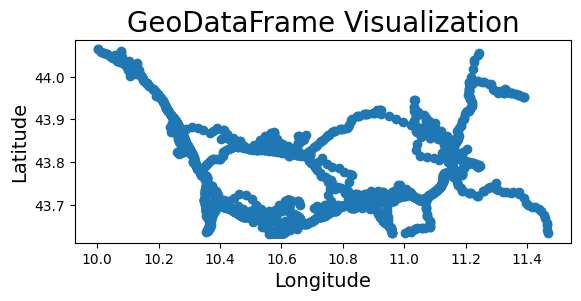

In [245]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))  # Set width and height in inches
gdf3_FIPILI.head(2000).plot()


plt.title("GeoDataFrame Visualization", fontsize=20)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)


plt.show()


In [88]:
# salviamo prima i gdfs singoli
import paramiko
import geopandas as gpd
import pandas as pd
import io
# Configurazione
hostname = "kddrtserver10.isti.cnr.it"
username = "avitali"

try:
    #apro connessione ssh
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)

    sftp = ssh.open_sftp()

    
    for date, gdf in gdfs_LASTRA_GINESTRA_Timestamps.items():
        print(f"Saving gdf {date} with head of {gdf.head(1)}")
        with sftp.open(f"/home/avitali/Filtered_LASTRA_GINESTRA_{date}.geojson", "w") as file:
            file.write(gdf.to_json())

        print(f"GeoJSON file {date} saved successfully as /home/avitali/Filtered_LASTRA_GINESTRA_{date}.geojson")
        print("")
    #chiudo sdfp e ssh
    sftp.close()
    ssh.close()

except Exception as e:
    print(f"An error occurred: {e}")


Saving gdf 20190211 with head of         ID        Date      Time   Latitude  Longitude  Speed  Heading  \
1789  2257  2019-02-11  05:12:13  43.636185  11.007221     90       52   

      PanelSession  DeltaPos                   geometry            Timestamp  
1789             1      2042  POINT (11.00722 43.63618)  2019-02-11 05:12:13  
GeoJSON file 20190211 saved successfully as /home/avitali/Filtered_LASTRA_GINESTRA_20190211.geojson

Saving gdf 20190212 with head of       ID        Date      Time   Latitude  Longitude  Speed  Heading  \
618  996  2019-02-12  08:01:30  44.010111  11.238962     58      140   

     PanelSession  DeltaPos                   geometry            Timestamp  
618             1      2017  POINT (11.23896 44.01011)  2019-02-12 08:01:30  
GeoJSON file 20190212 saved successfully as /home/avitali/Filtered_LASTRA_GINESTRA_20190212.geojson

Saving gdf 20190213 with head of         ID        Date      Time   Latitude  Longitude  Speed  Heading  \
1575  2257  2019-

### Salvataggio Concatenato

In [89]:
## salvataggio

import paramiko
import geopandas as gpd
import pandas as pd
import io
# Configurazione
hostname = "kddrtserver10.isti.cnr.it"
username = "avitali"
merged_output_path = "/home/avitali/LASTRA_GINESTRA_filtered_2_Settimana_Febbraio.geojson"

try:
    #apro connessione ssh
    print("Connecting to SSH server...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)
    print("Connection to SSH server established")

    print("Opening sftp connection...")
    sftp = ssh.open_sftp()
    print("sftp connection opened")

    print("Concatenating gdfs...")
    merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs_LASTRA_GINESTRA_Timestamps.values(), ignore_index=True))
    print(f"Gdfs concatenated and has {len(merged_gdf)} rows")

    print("Saving file...")
    with sftp.open(merged_output_path, "w") as merged_file:
        merged_file.write(merged_gdf.to_json())
        
     
    # Verifica della dimensione del file
    attrs = sftp.stat(merged_output_path)
    print(f"Merged GeoJSON file saved successfully at {merged_output_path}")
    print(f"File size: {attrs.st_size} bytes")


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    #chiudo sdfp e ssh
    try:
        sftp.close()
        ssh.close()
    except Exception as cleanup_error:
        print(f"Error during cleanup: {cleanup_error}")




Connecting to SSH server...
Connection to SSH server established
Opening sftp connection...
sftp connection opened
Concatenating gdfs...
Gdfs concatenated and has 271468 rows
Saving file...
Merged GeoJSON file saved successfully at /home/avitali/LASTRA_GINESTRA_filtered_2_Settimana_Febbraio.geojson
File size: 88459014 bytes
